# Kuprenas et al. 2018 modification to the Winterwerp formulation for average floc size

This notebook contains the information needed to play around with:
1. the solution to the time-dependent ODE for floc size as presented in Kuprenas et al. 2018, and 
2. the equilibrium floc size given a range of turbulent shear rates and two concentration levels.

The **time-dependent ODE** solved is:

\begin{equation}
\frac{dD}{dt}=\underbrace{\frac{k_{A}^{'}}{n_{f}}\frac{{D_{p}}^{n_{f}-3}}{\rho _{s}}GCD^{4-n_{f}}}_{A}-\underbrace{\frac{k_{B}^{'}}{n_{f}}D G\left(\frac{D-D_p}{D_p}\right)^p\left(\frac{\tau_{t}}{\tau_{y}}\right)^q}_{B}
\label{eq:W98}
\end{equation}

with, $\tau_{t}=\mu G$, $\tau_{y}=F_y/D^2$, and $q = c_{1}+c_{2}D/\eta$. The rest of variables definitions can be found in the paper.

The **equilibrium floc size** comes from setting $dD/dt=0$ in the above and solving for $D$ (or $D_e$):

\begin{equation}
D_{e}=\left[\left(\frac{k_{A}^{'}}{k_{B}^{'}}\frac{1}{\rho_{s}}\right)D_{p}^{n_{f}+p-3}C\left(\frac{\mu}{F_{y}}\right)^{-q}G^{-q}\right]^{1/(2q+p+n_{f}-3)}
\label{eq:De1}
\end{equation}

## Imports and function definitions

In [1]:
# Imports
%pylab inline
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# The modified W98 ODE to be integrated: dDdt = A-B
def dDdtW98M(D, t, Ka, Kb, nf, Dp, c2, C, G): 
    q = c1+c2*D/sqrt(nu/G)
    A = Ka*(Dp**(nf-3)/(nf*rhos))*G*C*D**(4-nf) # aggregation term
    B = Kb*((Dp**(-p))/nf)*(mu/Fy)**q*G**(q+1)*(D-Dp)**p*D**(2*q+1) # breakup term
    dDdt = A-B
    return dDdt

def W98Meq(De,Ka, Kb,Fy, c2, C, G):
    q = c1+c2*De/sqrt(nu/G)
    return De-(Ka/(Kb*rhos))**(1/(2*q))*(mu/Fy)**(-1/2)*C**(1/(2*q))*G**(-1/2)
    
def density(To,Sppt):
    rho_fresh=1000*(1-(To +288.9414)/(508929.2*(To+68.12963))*(To-3.9863)**2)
    Acoef = 0.824493 - 0.0040899*To + 0.000076438*To**2 -0.00000082467*To**3 + 0.0000000053675*To**4
    Bcoef = -0.005724 + 0.00010227*To - 0.0000016546*To**2
    return rho_fresh + Acoef*Sppt + Bcoef*Sppt**(3/2) + 0.00048314*Sppt**2

def visc(To):
    return 2.7488e-07+1.4907e-06*exp(-0.034812*To)

Populating the interactive namespace from numpy and matplotlib


## Solution to time-dependent ODE

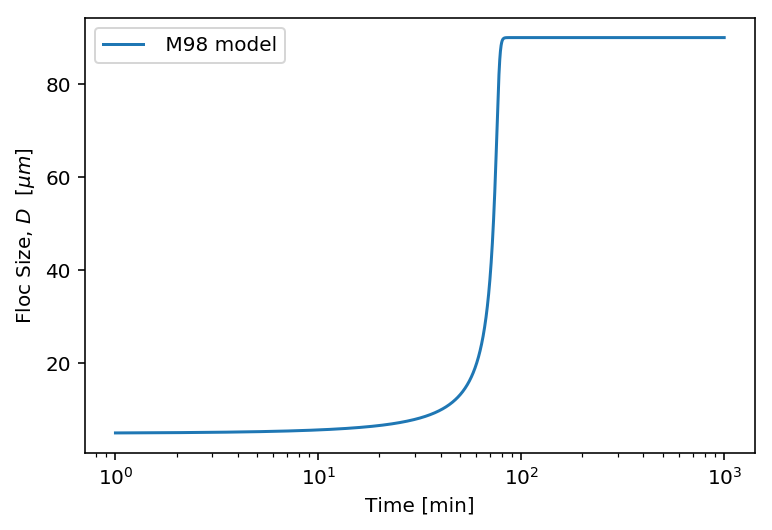

In [2]:
"""
User input --------------------------------------------------------
"""
# Fluid properties 
G = 50.          # turbulent shear rate[s-1]
To = 20          # temperature in degC
Sppt = 0         # salinity in parts per thousand 

# Sediment properties
C = 50/10**3     # suspended sediment concentration [g/L]
Dp = 5/10**6     # primary particle size [m]
Fy = 1e-10       # floc yeild strength [N]
rhos = 2650.     # sediment density [kg/m3]
nf = 2.0         # fractal dimension

# Calculation inputs 
tstart_min = 1   # minute to start the integration at
tend_min = 1000  # minute to end the integration at
D0 = Dp #50/10**6    # floc size at tstart_min [m]
Npts = 10000     # number of points in calculation

# initial guess for fit values (change if there are convergence issues) 
Ka = 0.45
Kb = 1.16e-6

# coefficients for modification to q
c1 = 0.5
c2 = 1.5

"""
Setup calculations ----------------------------------------------------
"""
# Pre-integration calcs and array setup
rho = density(To,Sppt)
nu = visc(To)
mu = nu*rho
p = 3.-nf
eta = sqrt(nu/G)

# Setup time array for integration
t = linspace(tstart_min*60,tend_min*60,Npts)

"""
Integrate and plot -----------------------------------------------------
"""

# Solution to the ODE D'(t) = dDdt(D, t, Ka, Kb) with initial condition D(0) = D0

D = odeint(dDdtW98M, D0, t, args=(Ka, Kb, nf, Dp, c2, C, G))

Dfe = D[-1]    # equilibrium model floc size in [m]

# Plot and print the results
fig, ax = plt.subplots()
ax.plot(t/60,D*10**6, label=' M98 model')
ax.set_xscale('log'),
ax.set_xlabel('Time [min]')
ax.set_ylabel('Floc Size, $D$  [$\mu m$]')
legend(loc=2);

## Equilibrium size as a function of $G$

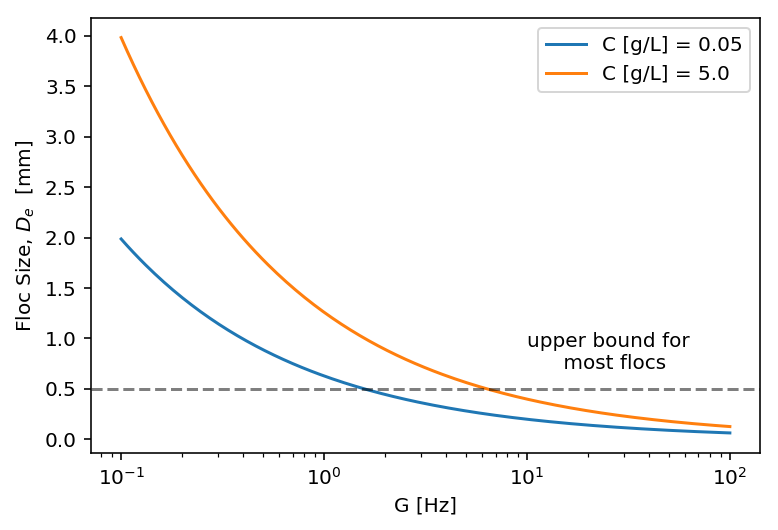

In [3]:
"""
User input --------------------------------------------------------
"""

# Fluid properties 
Glower = 0.1   # turbulent shear rate lower bound [s-1]
Gupper = 100     # turbulent shear rate upper bound [s-1]     
To = 20          # temperature in degC
Sppt = 0         # salinity in parts per thousand 

# Sediment properties
Clower = 50/10**3     # lower bound on suspended sediment concentration [g/L]
Cupper = 5000/10**3    # upper bound on suspended sediment concentration [g/L]
Dp = 5/10**6          # primary particle size [m]
Fy = 1e-10            # floc yeild strength [N]
rhos = 2650.          # sediment density [kg/m3]
nf = 2.0              # fractal dimension

# Model inputs initial guess for fit values (change if there are convergence issues) 
Ka = 0.45
Kb = 1.16e-6
c1 = 0.5
c2 = 1.5
p = 3.-nf

"""
Calculations ----------------------------------------------------
"""

rho = density(To,Sppt)
nu = visc(To)
mu = nu*rho


NumG = 200
Grange = logspace(log10(Glower),log10(Gupper),NumG)
DfeG1 = zeros(NumG)
DfeG2 = zeros(NumG)

# calculate the equilibrium floc size as a function of the G array, C values, and user inputs

for i in range(0,NumG):
    DfeG1[i] = fsolve(W98Meq,sqrt(nu/Grange[i]), args=(Ka, Kb, Fy, c2, Clower, Grange[i]))
    DfeG2[i] = fsolve(W98Meq,sqrt(nu/Grange[i]), args=(Ka, Kb, Fy, c2, Cupper, Grange[i]))
    
"""
Plot ----------------------------------------------------
"""

fig, ax = plt.subplots()
ax.plot(Grange,DfeG1*10**3, label='C [g/L] = '+str(Clower))
ax.plot(Grange,DfeG2*10**3, label='C [g/L] = '+str(Cupper))
ax.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)
ax.set_xscale('log')
ax.set_xlabel('G [Hz]')
ax.set_ylabel('Floc Size, $D_{e}$  [mm]')
legend(loc=1)
ax.text(10,0.7, 'upper bound for \n most flocs', 
        clip_on='True', multialignment='center', alpha=1);